In [1]:
from gensim import models

from IPython.display import display, HTML

Couldn't import dot_parser, loading of dot files will not be possible.


In [43]:
m = models.word2vec.Word2Vec.load("models/word2vec/cbow/model.txt")
#m = models.word2vec.Word2Vec.load("models/word2vec/all_pages.txt")

In [44]:
questions = [ "philosophy", "science", "religion", "knowledge", "wisdom", "love" ]

partitions = [ [["philosophy"],[]],
              [["continental_philosophy"],["analytic_philosophy"]],
              [["analytic_philosophy"],["continental_philosophy"]]]

In [45]:
def print_questions(answers):
    html = "<table>"

    html += """
    <tr>
      <td></td>
      <th>philosophy</th>
      <th>continental philosophy</th>
      <th>analytic philosophy</th>
    </tr>
    """
    
    for question, control, analytic, continental in answers:
        html += "<tr><td style=\"width: 100px; text-align: center; \"><h3>%s</h3></td>" % question
        html += "<td><ul>"
        html += "\n".join([ "<li>%s</li>" % word for word, score in control ])
        html += "</ul></td>"
        html += "<td><ul>"
        html += "\n".join([ "<li>%s</li>" % word for word, score in analytic ])
        html += "</ul></td>"
        html += "<td><ul>"
        html += "\n".join([ "<li>%s</li>" % word for word, score in continental ])
        html += "</ul></td>"
        html += "</tr>"
    
    html += "</table>"

    display(HTML(html))

def q(positive, negative, model):
  try:
    result = model.most_similar(positive=positive, negative=negative)
  except:
    result = []
  
  return result

print_questions([ ([question]+[ q(p[0]+[question], p[1], m) for p in partitions]) for question in questions ])

,philosophy,continental philosophy,analytic philosophy
philosophy,psychology mathematics philosophy_science metaphysics moral_philosophy ethics philosophy_religion theology logic analytic_philosophy,philosophy_religion philosophy_science psychology western_philosophy ethics political_philosophy theology new_reasoner moral_philosophy metaphysics,mathematics psychology logic metaphysics moral_philosophy physics philosophy_science ethics philosophical natural_sciences
science,psychology philosophy_science mathematics ethics moral_philosophy philosophy_religion medicine physics metaphysics logic,sciences philosophy_science anthropology ethics social_sciences psychology science_technology technology humanities philosophy_religion,psychology mathematics knowledge physics logic biology natural_sciences ethics medicine sciences
religion,theology judaism ethics philosophy_religion metaphysics mysticism psychology spirituality science christian_theology,judaism christian christianity roman_catholicism theology smith_huston humanism spirituality church_state history_religions,theology judaism christianity faith christian paul_tillich's spirituality orthodoxy buddhist enlightenment
knowledge,metaphysics psychology mathematics logic natural_science ethics natural_sciences moral_philosophy skepticism scepticism,understanding human_nature objectivity dimension creativity scepticism reality supernaturalism morality consciousness,understanding perception distinction analogy natural_sciences holds intellect revelation insight basic
wisdom,knowledge spirituality philosophy's ethics metaphysics zen theology mysticism paul_tillich's scepticism,yahweh spirit mysteries imagination sacred faith jesus quest beauty soul,revelation beauty redemption divine immortality spirit true cosmos soul scripture
love,aramis wisdom sex beauty passion meditation nature immortality revelation spirit,beauty dark heart passion grace joy beautiful heaven wild shadow,beauty heart beautiful strange mystery passion my joy dark man's


In [46]:
import numpy as np

In [47]:
A_question = np.array([ m[question] for question in questions ])

In [48]:
A_philosophy = reduce(lambda a,b: a+b, [ q(["philosophy", m[question]], [], m) for question in questions ])
A_philosophy = np.array([ m[w] for w,s in A_philosophy ])

In [49]:
A_continental = reduce(lambda a,b: a+b, [ q(["continental_philosophy", m[question]], ["analytic_philosophy"], m) for question in questions ])
A_continental = np.array([ m[w] for w,s in A_continental ])

In [50]:
A_analytic = reduce(lambda a,b: a+b, [ q(["analytic_philosophy", m[question]], ["continental_philosophy"], m) for question in questions ])
A_analytic = np.array([ m[w] for w,s in A_analytic ])

## Principal Component Analysis

In [51]:
from sklearn.decomposition import PCA

In [52]:
pca = PCA(n_components=2)

A = np.append(A_question, A_philosophy, axis=0)
A = np.append(A, A_continental, axis=0)
A = np.append(A, A_analytic, axis=0)

pca = pca.fit(A)

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull

In [54]:
s1 = partitions[0] + [ ".70" ]
s2 = partitions[1] + [ "red" ]
s3 = partitions[2] + [ "blue" ]

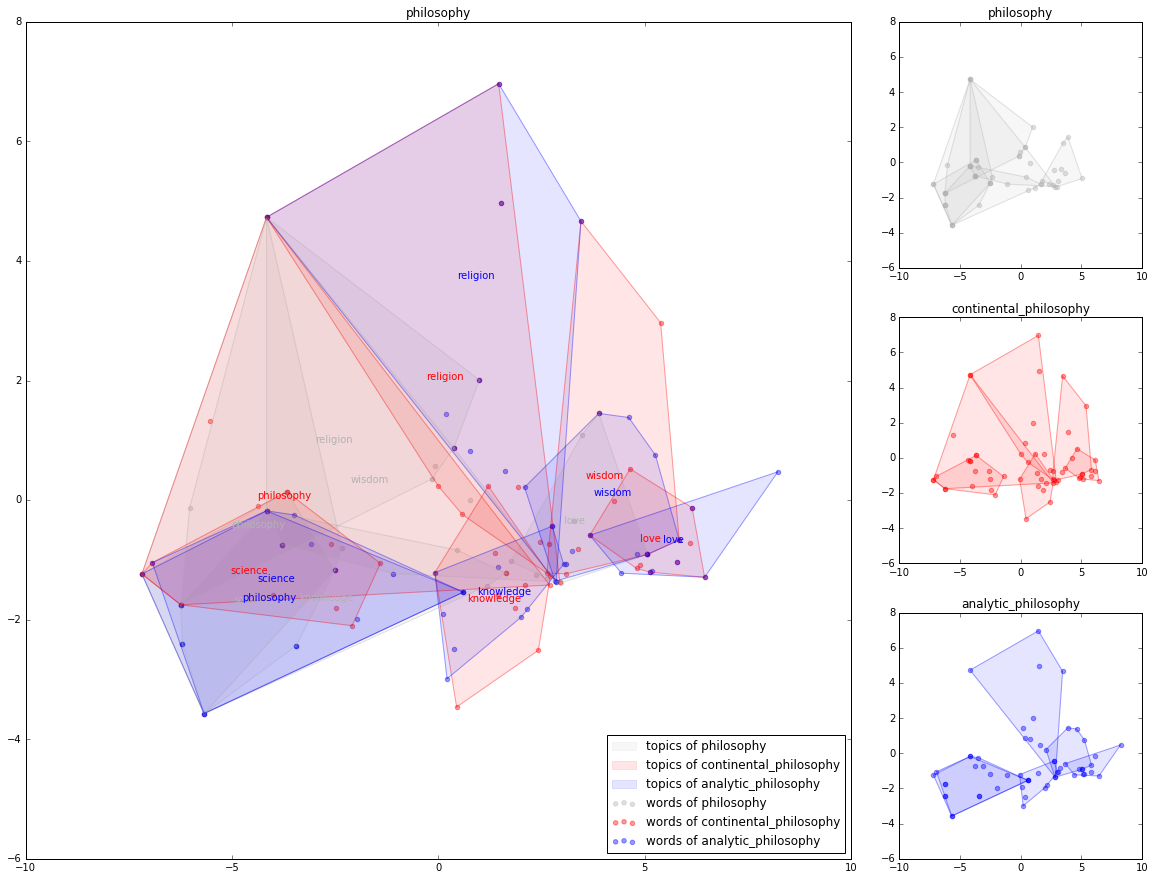

In [55]:
def plot_words(ax, s, label=False, legend=False):
  
  ax.set_title(s[0][0][0])
  
  s = [ (p+[question],n,c) for (p,n,c) in s for question in questions  ]
  
  points_label = {}
  groups = {}
  
  for p, n, c in s:
    Z = pca.transform(np.array([ m[w] for w,s in q(p,n,m) ]))

    hull = ConvexHull(Z)

    for simplex in hull.simplices:
      ax.plot(Z[simplex, 0], Z[simplex, 1], '-', color=c, alpha=0.3)

    simplex_x, simplex_y = ([], [])

    for simplex in hull.vertices:
      simplex_x.append(Z[simplex, 0])
      simplex_y.append(Z[simplex, 1])

    if label:
      ax.text(np.mean(simplex_x), np.mean(simplex_y), p[1], color=c, horizontalalignment='center', verticalalignment='center',)
      
    groups[p[0]] = ax.fill(simplex_x, simplex_y, '', color=c, alpha=0.1)

    Z_ = zip(*Z)
    
    points_label[p[0]] = ax.scatter(Z_[0], Z_[1], lw=1, color=c, alpha=0.4)

  if legend:
    ax.legend([ v[0] for v in groups.values() ] \
                + [ v for v in points_label.values() ],\
              [ "topics of %s" % k for k in groups.keys() ]\
                + [ "words of %s" % k for k in points_label.keys() ],\
             loc='lower right')

fig = plt.figure(figsize=(20,15))

ax1 = plt.subplot2grid((3,4), (0, 0), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((3,4), (0, 3), sharex=ax1, sharey=ax1)
ax3 = plt.subplot2grid((3,4), (1, 3), sharex=ax1, sharey=ax1)
ax4 = plt.subplot2grid((3,4), (2, 3), sharex=ax1, sharey=ax1)
        
plot_words(ax1, [s1]+[s2]+[s3], label=True, legend=True)
plot_words(ax2, [s1])
plot_words(ax3, [s2])
plot_words(ax4, [s3])


plt.show()

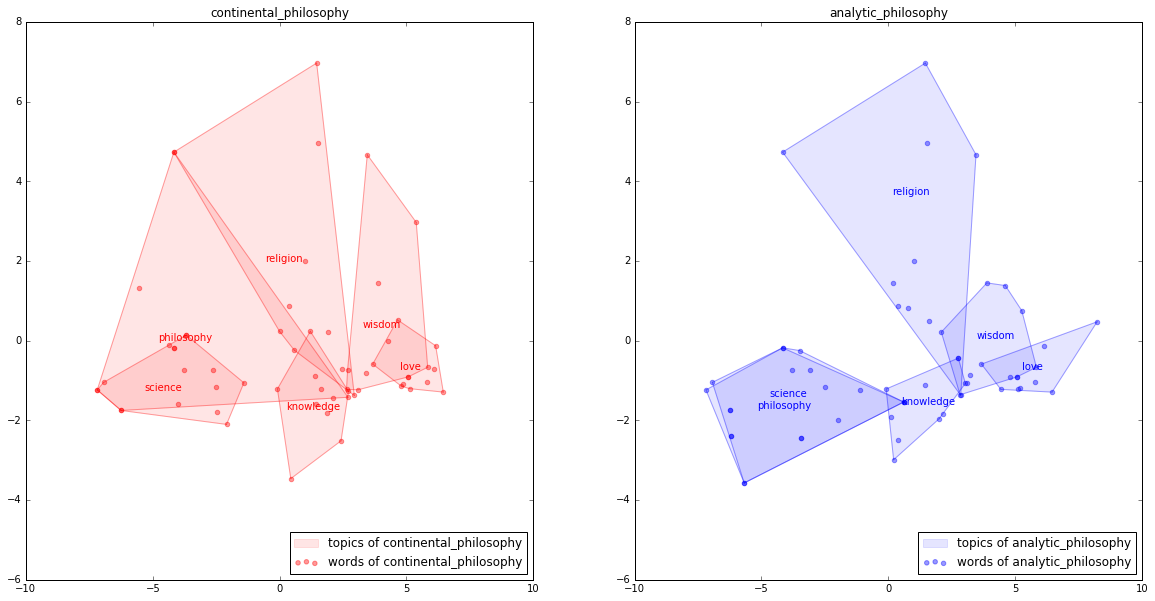

In [56]:
fig = plt.figure(figsize=(20,10))

ax1 = plt.subplot2grid((1,2), (0, 0))
ax2 = plt.subplot2grid((1,2), (0, 1), sharex=ax1, sharey=ax1)

plot_words(ax1, [s2], label=True, legend=True)
plot_words(ax2, [s3], label=True, legend=True)

plt.show()

## t-SNE dimensionality reduction

In [20]:
from sklearn.manifold import TSNE
import pandas as pd

In [ ]:
y = np.zeros(len(A_question))
y = np.append(y, np.zeros(len(A_philosophy)))
y = np.append(y, np.ones(len(A_analytic)))
y = np.append(y, np.ones(len(A_continental)) * -1)

In [82]:
answers = [ (question, [ x[0] for x in q(p[0]+[question], p[1], m)]) for p in partitions for question in questions ]
answers = answers + [ (question, [ question ]) for question in questions ]
df = pd.DataFrame(columns=questions)

for question, words in answers:
  for word in words:
    df.loc[word, question] = 1

    
df = df.fillna(0)

y2 = map(lambda x: list(df.loc[x,:]), reduce(lambda a,b: a+b, [ x[1] for x in answers ]))

In [84]:
tsne = TSNE(n_components=2)
tsne = tsne.fit(A)

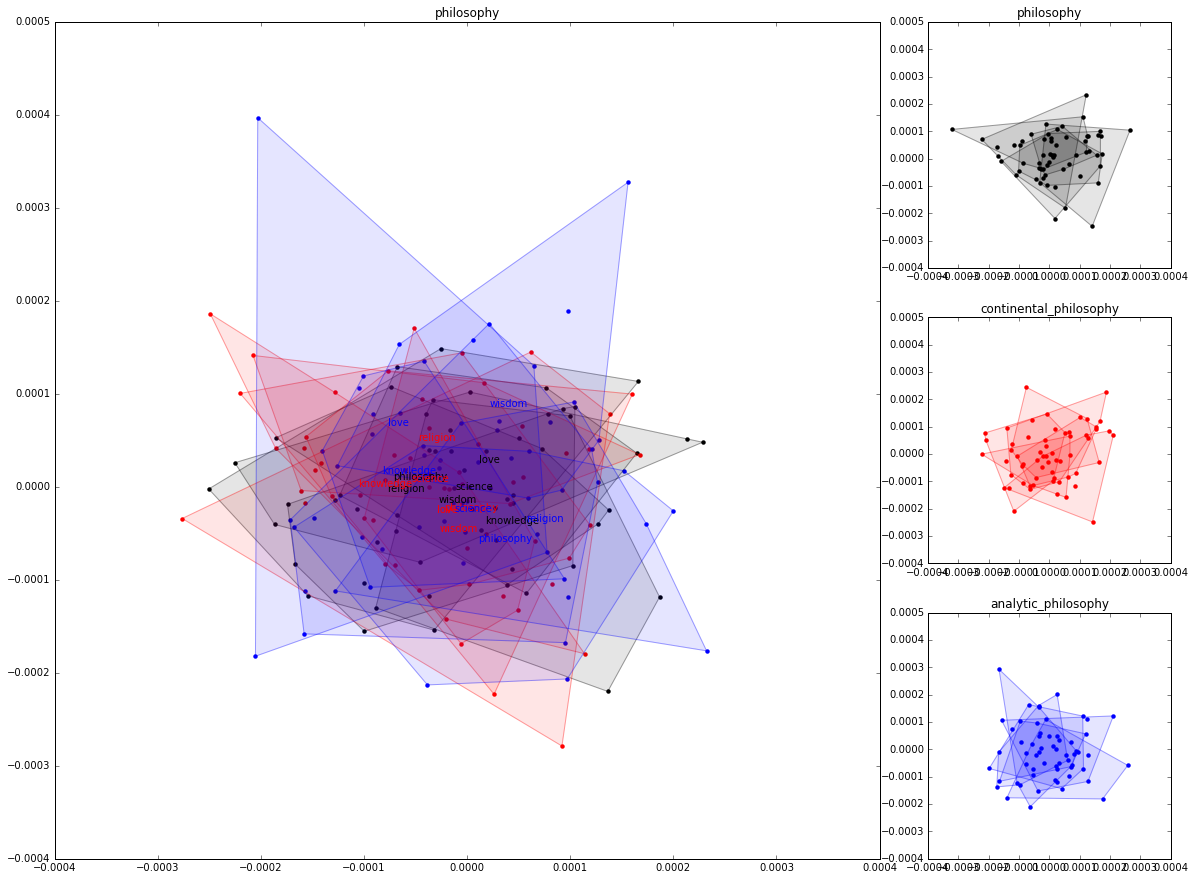

In [85]:
fig = plt.figure(figsize=(20,15))

ax1 = plt.subplot2grid((3,4), (0, 0), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((3,4), (0, 3), sharex=ax1, sharey=ax1)
ax3 = plt.subplot2grid((3,4), (1, 3), sharex=ax1, sharey=ax1)
ax4 = plt.subplot2grid((3,4), (2, 3), sharex=ax1, sharey=ax1)

s1 = partitions[0] + [ "black" ]
s2 = partitions[1] + [ "red" ]
s3 = partitions[2] + [ "blue" ]

def plot_words(ax, s, label=False):
  
  ax.set_title(s[0][0][0])
  
  s = [ (p+[question],n,c) for (p,n,c) in s for question in questions  ]

  for p, n, c in s:
    Z = tsne.fit_transform(np.array([ m[w] for w,s in q(p,n,m) ]))

    hull = ConvexHull(Z)

    for simplex in hull.simplices:
      ax.fill(Z[simplex, 0], Z[simplex, 1], '-', color=c, alpha=0.3)

    simplex_x = []
    simplex_y = []

    for simplex in hull.vertices:
      simplex_x.append(Z[simplex, 0])
      simplex_y.append(Z[simplex, 1])

    if label:
      ax.text(np.mean(simplex_x), np.mean(simplex_y), p[1], color=c, horizontalalignment='center', verticalalignment='center',)
      
    simplex_x.append(Z[hull.vertices[0], 0])
    simplex_y.append(Z[hull.vertices[0], 1])

    ax.fill(simplex_x, simplex_y, '-', color=c, alpha=0.1)

    Z_ = zip(*Z)

    ax.scatter(Z_[0], Z_[1], lw=0, color=c)

plot_words(ax1, [s1]+[s2]+[s3], label=True)
plot_words(ax2, [s1])
plot_words(ax3, [s2])
plot_words(ax4, [s3])

plt.show()

In [91]:
def run_queries(model_path, queries):
  m = models.word2vec.Word2Vec.load(model_path+"/model.txt")

  result = {}

  for query in queries:
    q = " +".join(query[0]) + " -" +" -".join(query[1])

    try:
      result[q] = m.most_similar(positive=query[0], negative=query[1], topn=10)
    except:
      result[q] = []

  return result

def confirm(results, n=10):
  links = [
    ["analytic_philosophy +science -continental_philosophy", "analytic_philosophy +love -continental_philosophy"],
    ["continental_philosophy +science -analytic_philosophy", "continental_philosophy +philosophy -analytic_philosophy"],
    ["continental_philosophy +religion -analytic_philosophy", "continental_philosophy +philosophy -analytic_philosophy"],
    ["analytic_philosophy +science -continental_philosophy", "analytic_philosophy +philosophy -continental_philosophy"],
    ["analytic_philosophy +science -continental_philosophy", "analytic_philosophy +knowledge -continental_philosophy"],
    ["analytic_philosophy +knowledge -continental_philosophy", "analytic_philosophy +wisdom -continental_philosophy"]
  ]

  holes = [
    ["analytic_philosophy +religion -continental_philosophy", "analytic_philosophy +philosophy -continental_philosophy"],
    ["continental_philosophy +science -analytic_philosophy", "continental_philosophy +knowledge -analytic_philosophy"]
  ]

  topics = { key: [ x[0] for x in result[0:n] ] for key, result in results.iteritems() }

  # print topics

  #return { "links": [ ( len(set(topics[l[0]])), len(set(topics[l[1]])) ) for l in links ],
  #  "holes": [ (len(set(topics[l[0]])), len(set(topics[l[1]])) )  for l in holes ]
  #}

  return {
    "content": {
      "links": [ list(set(topics[l[0]]) & set(topics[l[1]]))  for l in links ],
      "holes": [ list(set(topics[l[0]]) & set(topics[l[1]]))  for l in holes ]
    },
    "confirmation": {
      "links": [ len(set(topics[l[0]]) & set(topics[l[1]])) > 0 for l in links ],
      "holes": [ len(set(topics[l[0]]) & set(topics[l[1]])) == 0 for l in holes ]
    }
  }

In [92]:
results = run_queries("models/word2vec/cbow", [ [p[0]+[q], p[1]] for q in questions for p in partitions ])

In [93]:
print confirm(results)

{'content': {'holes': [[], []], 'links': [[], [u'philosophy_science', u'ethics', u'psychology', u'philosophy_religion'], [u'theology'], [u'psychology', u'logic', u'mathematics', u'ethics', u'natural_sciences', u'physics'], [u'natural_sciences'], [u'revelation']]}, 'confirmation': {'holes': [True, True], 'links': [False, True, True, True, True, True]}}
